# Author Identification 

## Part-1

### Import Libraries

In [107]:
import numpy as np
import pandas as pd
import os
from nltk import word_tokenize
from nltk.corpus import words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score , confusion_matrix , accuracy_score
from sklearn.svm import SVC
import plot_confusion_matrix
import matplotlib.pyplot as plt
import glob , itertools , add_feature

%matplotlib inline

### Create Dataset from author folders (Reuters C-50 dataset) 

In [108]:
num_authors = [] ## Number of authors to test the model on.
df = pd.DataFrame()

dfs=[]
author_names = sorted(os.listdir('text_corpus/C50train/'))
number_authors = len(author_names)
for authors in author_names:
    article_corpus=[]
    for file in glob.glob(os.path.join('text_corpus/C50train',authors,'*.txt')):
        with open(file) as fh:
            article_corpus.append(fh.read())

    dfs.append(pd.DataFrame({'Story':article_corpus , 'Author':authors}))

dataset = pd.concat(dfs , axis=0)
for author_idx in range(0,50*number_authors,50):
    vect = TfidfVectorizer().fit_transform(dataset.iloc[author_idx:author_idx+50,1])
    similarity = (vect * vect.T).A
    
    visited = np.zeros([50])
    for i in range(50):
        if(not visited[i]):
            visited[i] = 1
            idx = similarity[i,:] > 0.6
            sim_list = np.where(idx)[0]
            if len(sim_list) > 0:
                for doc_id in sim_list[1:]:
                    dataset.iloc[author_idx+doc_id,1] = np.nan
                    visited[doc_id] = 1

dataset = dataset.dropna()
counts = dataset.groupby('Author').agg('count').reset_index()
author_shortlist = counts.sort_values('Story',ascending=False).iloc[10:20,0].values
dataset_valid = dataset[dataset['Author'].isin(author_shortlist)].reset_index(drop=True)

#### Change labels to encoding

In [109]:
encoding = LabelEncoder().fit(dataset_valid['Author'])
author_ids = list(encoding.transform(dataset_valid['Author']))
dataset_valid['Author_id'] = author_ids

### Build Model and Train

#### Train-test split the data

In [110]:
X_train , X_val , y_train , y_val = train_test_split(dataset_valid['Story'].values , dataset_valid['Author_id'].values , test_size=0.1)

#### Build the features using tf-idf vectorizer

In [111]:
vect = TfidfVectorizer(min_df=7,max_df=0.90,ngram_range=(2,5),analyzer='char_wb').fit(X_train)
X_train_transform = vect.transform(X_train)
X_val_transform = vect.transform(X_val)

#### Model using linear SVC

In [117]:
model = SVC(kernel='linear',C=10,class_weight='balanced')
model.fit(X_train_transform , y_train)

predictions = model.predict(vect.transform(X_val))

score_f1 = f1_score(y_val , predictions , average='weighted')
score_acc = accuracy_score(y_val , predictions)

# print('Number of authors' , len(author_shortlist))
# print('Obtained f1 accuracy: ' , score_f1*100)
# print('Obtained accuracy' , score_acc*100)

Confusion matrix, without normalization


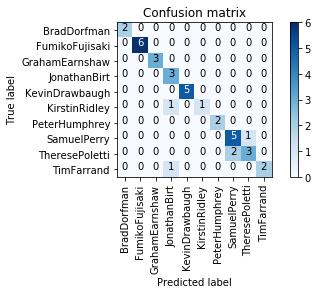

In [113]:
cmat = confusion_matrix(y_val , predictions)
plot_confusion_matrix.plot_confusion_matrix(cmat , encoding.classes_ )

## Test set Generation

In [114]:
dfs_test=[]
author_names = sorted(os.listdir('text_corpus/C50test/'))
number_authors_test = len(author_names)
for authors in author_names:
    article_corpus=[]
    for file in glob.glob(os.path.join('text_corpus/C50test',authors,'*.txt')):
        with open(file) as fh:
            article_corpus.append(fh.read())

    dfs_test.append(pd.DataFrame({'Story':article_corpus , 'Author':authors}))

dataset_test = pd.concat(dfs_test , axis=0)
dataset_test = dataset_test.dropna()
dataset_test_valid = dataset_test[dataset_test['Author'].isin(author_shortlist)].reset_index(drop=True)

dataset_test_valid['Author_id'] = list(encoding.transform(dataset_test_valid['Author']))

X_test = dataset_test_valid['Story']
y_test = dataset_test_valid['Author_id']

predictions = model.predict(vect.transform(X_test))

score_f1 = f1_score(y_test , predictions , average='weighted')
score_acc = accuracy_score(y_test , predictions)

print('Number of authors' , len(author_shortlist))
print('Obtained f1 accuracy: ' , score_f1*100)
print('Obtained accuracy' , score_acc*100)

Number of authors 10
Obtained f1 accuracy:  91.2297313011
Obtained accuracy 91.2


Confusion matrix, without normalization


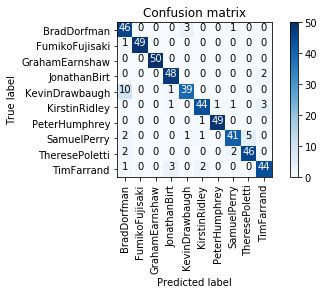

In [115]:
cmat = confusion_matrix(y_test , predictions)
plot_confusion_matrix.plot_confusion_matrix(cmat , encoding.classes_ )

### Train using all the data

In [88]:
X_total = dataset_valid['Story'].values
y_total = dataset_valid['Author_id'].values

vect = TfidfVectorizer(min_df=7,max_df=0.90,ngram_range=(3,5),analyzer='char_wb').fit(X_total)
X_total_transform = vect.transform(X_total)
model_total = SVC(kernel='linear',C=10,class_weight='balanced')
model_total.fit(X_total_transform , y_total)

predictions_total = model_total.predict(vect.transform(X_test))

score_f1 = f1_score(y_test , predictions_total , average='weighted')
score_acc = accuracy_score(y_test , predictions_total)

print('Number of authors: ' , len(author_shortlist))
print('Obtained f1 accuracy: ' , score_f1*100)
print('Obtained accuracy' , score_acc*100)

Number of authors:  10
Obtained f1 accuracy:  91.6082742018
Obtained accuracy 91.6


Confusion matrix, without normalization


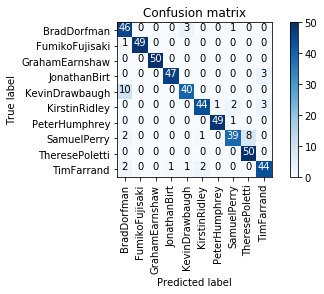

In [49]:
cmat = confusion_matrix(y_test , predictions_total)
plot_confusion_matrix.plot_confusion_matrix(cmat , encoding.classe